# Importing packages 

In [1]:
# Data wrangling 
import pandas as pd 

# Dates
from datetime import datetime

# Iteration tracking
from tqdm import tqdm
import time

# Array math
import numpy as np

# Ploting 
import matplotlib.pyplot as plt

# Xgboost models 
import xgboost as xgb

# Grid search for paramters
from sklearn.model_selection import ParameterGrid

# Reading train data 

In [28]:
d = pd.read_csv('train_data.csv', low_memory=False)

In [29]:
d.dtypes

Store              int64
DayOfWeek          int64
Date              object
Sales              int64
ShopOpen           int64
Promotion          int64
StateHoliday      object
SchoolHoliday      int64
StoreType         object
AssortmentType    object
dtype: object

In [30]:
print(f"Shape of data: {d.shape}")

Shape of data: (1017209, 10)


In [31]:
d.head(10)

,Store,DayOfWeek,Date,Sales,ShopOpen,Promotion,StateHoliday,SchoolHoliday,StoreType,AssortmentType
0,1,5,2015-07-31,5263,1,1,0,1,c,a
1,2,5,2015-07-31,6064,1,1,0,1,a,a
2,3,5,2015-07-31,8314,1,1,0,1,a,a
3,4,5,2015-07-31,13995,1,1,0,1,c,c
4,5,5,2015-07-31,4822,1,1,0,1,a,a
5,6,5,2015-07-31,5651,1,1,0,1,a,a
6,7,5,2015-07-31,15344,1,1,0,1,a,c
7,8,5,2015-07-31,8492,1,1,0,1,a,a
8,9,5,2015-07-31,8565,1,1,0,1,a,c
9,10,5,2015-07-31,7185,1,1,0,1,a,a


# Data preprocesing and feature engineering

In [32]:
# Converting to categorical all the categorical variables
cat_cols = [
    'Store', 
    'DayOfWeek', 
    'ShopOpen', 
    'Promotion', 
    'StateHoliday', 
    'SchoolHoliday', 
    'StoreType', 
    'AssortmentType'
]

d[cat_cols] = d[cat_cols].astype(str)

In [33]:
# Converting the Date column to datetime object
d['Date'] = [datetime.strptime(x, '%Y-%m-%d') for x in tqdm(d['Date'])]

# Getting the day of month 
d['day_of_month'] = [x.day for x in tqdm(d['Date'])]

100%|██████████| 1017209/1017209 [00:00<00:00, 1173235.49it/s]


## Adding the month of the year as a feature 

In [35]:
d['month_year'] = [str(x.month) for x in d['Date']]

In [36]:
d.sample(10)

,Store,DayOfWeek,Date,Sales,ShopOpen,Promotion,StateHoliday,SchoolHoliday,StoreType,AssortmentType,day_of_month,month_year
382569,392,1,2014-07-28,10333,1,1,0,1,a,a,28,7
256571,667,3,2014-12-10,8010,1,0,0,0,d,c,10,12
645791,992,6,2013-11-30,4639,1,0,0,0,a,a,30,11
947456,492,1,2013-03-04,10468,1,1,0,0,a,a,4,3
729605,66,7,2013-09-15,0,0,0,0,0,d,a,15,9
369148,1114,2,2014-08-12,19487,1,0,0,1,a,c,12,8
589692,643,7,2014-01-19,0,0,0,0,0,a,a,19,1
631249,945,5,2013-12-13,4915,1,0,0,0,a,c,13,12
711304,720,3,2013-10-02,7228,1,0,0,0,a,c,2,10
614840,146,5,2013-12-27,7497,1,0,0,1,d,c,27,12


## Unique categorical value list 

In [37]:
d[cat_cols + ['day_of_month', 'month_year']].nunique()

Store             1115
DayOfWeek            7
ShopOpen             2
Promotion            2
StateHoliday         4
SchoolHoliday        2
StoreType            4
AssortmentType       3
day_of_month        31
month_year          12
dtype: int64

## Distribution of the Y variable 

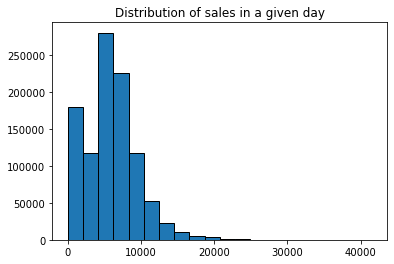

In [14]:
plt.hist(d['Sales'], edgecolor='black', bins=20)
plt.title('Distribution of sales in a given day')
plt.show()

In [15]:
# Descriptive stats
round(d['Sales'].describe(), 2)

count    1017209.00
mean        5773.82
std         3849.93
min            0.00
25%         3727.00
50%         5744.00
75%         7856.00
max        41551.00
Name: Sales, dtype: float64

# Feature list 

In [41]:
features = [
    "Store",
    'DayOfWeek', 
    'Promotion', 
    'StateHoliday', 
    'SchoolHoliday', 
    'StoreType', 
    'AssortmentType',
    'month_year',
    'day_of_month'
]

# Creating the final X and Y matrices 

In [44]:
X = pd.get_dummies(d[features])
Y = d['Sales']

In [45]:
print(f"Shape of X matrix: {X.shape}")
print(f"Shape of Y matrix: {Y.shape}")

Shape of X matrix: (1017209, 1150)
Shape of Y matrix: (1017209,)


# CPU and GPU speeds vs row count

In [77]:
# Defining the dictionaries
cpu_dict = {
    'objective': 'reg:squarederror'
}

gpu_dict = {
    'objective': 'reg:squarederror',
    'tree_method': 'gpu_hist'
}

# Number of rows to train on 
nrows = [
    10, 
    100, 
    200, 
    3000, 
    5000, 
    10000, 
    20000, 
    50000, 
    100000, 
    300000
]
cpu_speeds = []
gpu_speeds = []

for nrow in nrows: 
    # Sampling random rows 
    sample = d.sample(nrow)
    
    # Creating X and Y 
    X = pd.get_dummies(sample[features])
    Y = sample['Sales']
    
    # Initiating the model objects
    cpu = xgb.XGBRegressor(**cpu_dict)
    gpu = xgb.XGBRegressor(**gpu_dict)
    
    # Training on cpu 
    start = time.time()
    cpu.fit(X, Y)
    cpu_speed = time.time() - start
    
    # Training on gpu
    start = time.time()
    gpu.fit(X, Y)
    gpu_speed = time.time() - start
    
    # Appending the speed results 
    cpu_speeds.append(cpu_speed)
    gpu_speeds.append(gpu_speed)

# Creating a dataframe 
speeds = pd.DataFrame({
    'nrows': nrows,
    'cpu_speeds': cpu_speeds,
    'gpu_speeds': gpu_speeds
})

speeds['difference'] = speeds['cpu_speeds'] - speeds['gpu_speeds'] 

NameError: name 'gpu_peeds' is not defined

In [79]:
# Creating a dataframe 
speeds = pd.DataFrame({
    'nrows': nrows,
    'cpu_speeds': cpu_speeds,
    'gpu_speeds': gpu_speeds
})

speeds['difference'] = speeds['cpu_speeds'] - speeds['gpu_speeds'] 

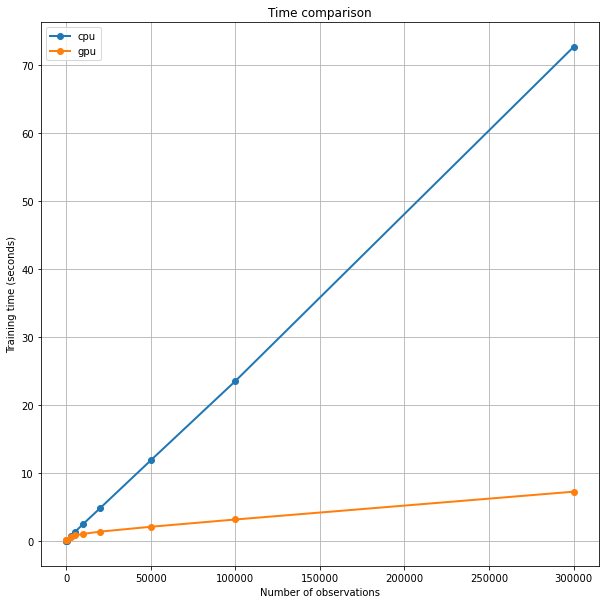

In [80]:
plt.figure(figsize=(10, 10))
plt.plot(nrows, cpu_speeds, '-o', label='cpu', linewidth=2)
plt.plot(nrows, gpu_speeds, '-o', label='gpu', linewidth=2)
plt.xlabel('Number of observations')
plt.ylabel('Training time (seconds)')
plt.title('Time comparison')
plt.legend()
plt.grid()
plt.show()

No handles with labels found to put in legend.


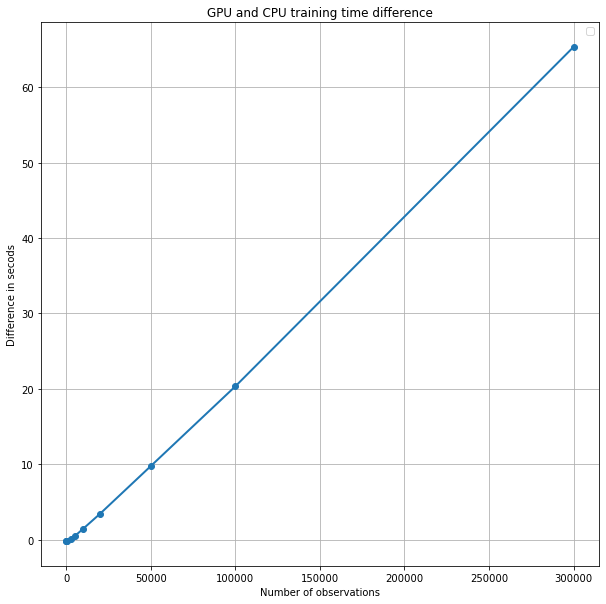

In [81]:
plt.figure(figsize=(10, 10))
plt.plot(speeds['nrows'], speeds['difference'], '-o', linewidth=2)
plt.xlabel('Number of observations')
plt.ylabel('Difference in secods')
plt.title('GPU and CPU training time difference')
plt.grid()
plt.show()

In [82]:
speeds

,nrows,cpu_speeds,gpu_speeds,difference
0,10,0.021004,0.163038,-0.142034
1,100,0.033007,0.198045,-0.165038
2,200,0.043009,0.227052,-0.184043
3,3000,0.797758,0.685154,0.112604
4,5000,1.337326,0.859194,0.478132
5,10000,2.537925,1.081355,1.456570
6,20000,4.858685,1.410637,3.448049
7,50000,11.895265,2.125650,9.769615
8,100000,23.532217,3.192972,20.339244
9,300000,72.613338,7.278566,65.334773


# Speed vs hp values

In [84]:
# Defining the grid of parameters 
n_estimators = [100, 200, 300]
max_depth = [12, 14, 16]

# Number of rows to test on 
nrows = 100000

# Creating a dictionary
gpu_dict = {
    'objective': ['reg:squarederror'], 
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'tree_method': ['gpu_hist']
}

cpu_dict = {
    'objective': ['reg:squarederror'], 
    'n_estimators': n_estimators,
    'max_depth': max_depth
}

# Creating the grid of hyper parameters 
gpu_hp = ParameterGrid(gpu_dict)
cpu_hp = ParameterGrid(cpu_dict)